In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
steps_csv_path = '/content/filtered_step_count_data.csv'
step_count_data = pd.read_csv(steps_csv_path)

In [ ]:
# Re-reading the weather data from the provided CSV
weather_data = pd.read_csv('/content/filtered_weather_data.csv')
weather_data.head()

,datetime,conditions
0,2023-09-01,Partially cloudy
1,2023-09-02,Partially cloudy
2,2023-09-03,"Rain, Partially cloudy"
3,2023-09-04,Partially cloudy
4,2023-09-05,"Rain, Partially cloudy"


In [ ]:
# Convert 'datetime' in weather data and 'startDate' in step count data to datetime for proper merging
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])
step_count_data['startDate'] = pd.to_datetime(step_count_data['startDate'])

# Merge the data on the dates that appear in both dataframes
merged_data = pd.merge(weather_data, step_count_data, left_on='datetime', right_on='startDate', how='inner')

# Dropping the duplicate 'datetime' column from the merge
merged_data.drop('datetime', axis=1, inplace=True)
# Renaming columns for clarity
merged_data.rename(columns={'startDate': 'Date', 'value': 'Total Steps', 'conditions': 'Weather Conditions'}, inplace=True)

# Displaying the merged data
merged_data

,Weather Conditions,Date,Total Steps
0,"Rain, Partially cloudy",2023-10-02,621.0
1,"Rain, Partially cloudy",2023-10-03,11309.0
2,Rain,2023-10-04,5580.0
3,Partially cloudy,2023-10-05,10851.0
4,Partially cloudy,2023-10-06,15525.0
...,...,...,...
86,Partially cloudy,2023-12-27,4856.0
87,Clear,2023-12-28,6420.0
88,Clear,2023-12-29,7408.0
89,Partially cloudy,2023-12-30,4408.0


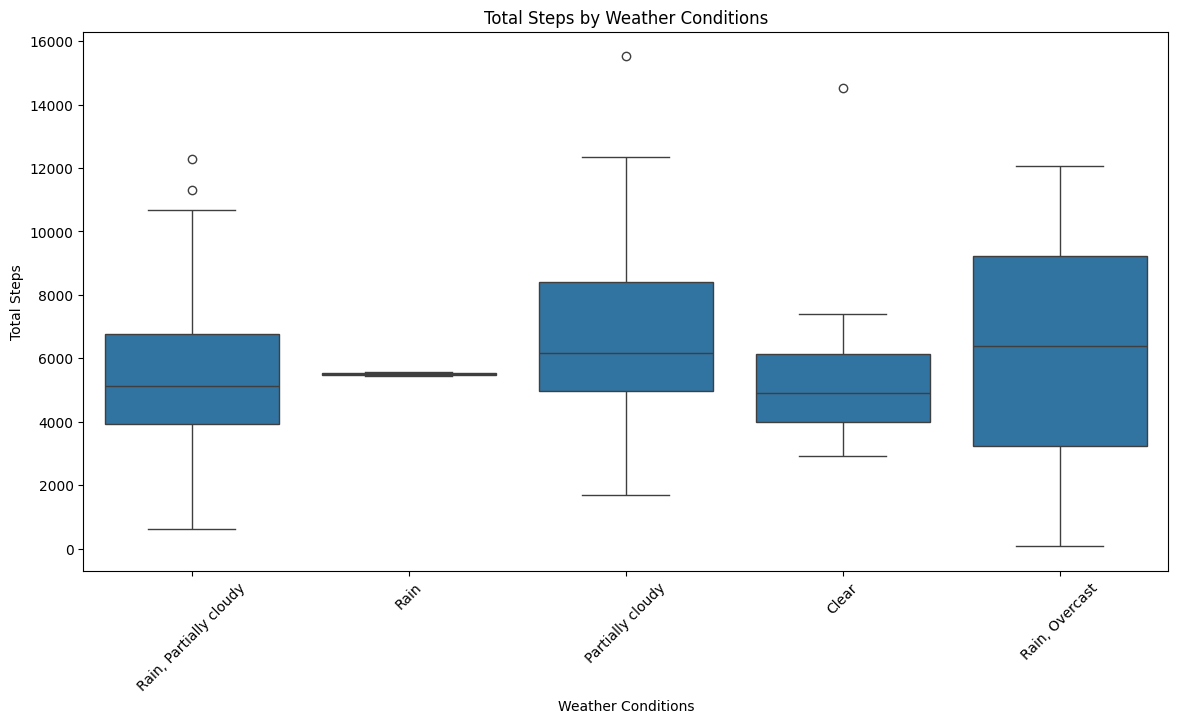

In [ ]:
import seaborn as sns

# Creating a boxplot to visualize the distribution of total steps for each weather condition
plt.figure(figsize=(14, 7))
sns.boxplot(x='Weather Conditions', y='Total Steps', data=merged_data)

# Adding title and labels to the plot
plt.title('Total Steps by Weather Conditions')
plt.xlabel('Weather Conditions')
plt.ylabel('Total Steps')

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45)

# Displaying the plot
plt.show()

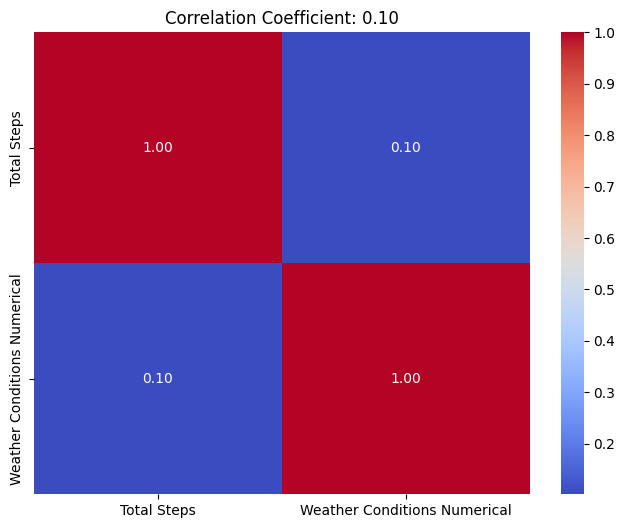

0.10178557607268593

In [ ]:
# Importing the required library for correlation analysis
import numpy as np

# For correlation analysis, we need to convert categorical weather conditions to numerical values.
# Creating a simple mapping for weather conditions
weather_conditions_mapping = {condition: idx for idx, condition in enumerate(merged_data['Weather Conditions'].unique())}
merged_data['Weather Conditions Numerical'] = merged_data['Weather Conditions'].map(weather_conditions_mapping)

# Calculating the correlation coefficient
correlation_matrix = merged_data[['Total Steps', 'Weather Conditions Numerical']].corr()
correlation_coefficient = correlation_matrix.iloc[0, 1]

# Creating a heatmap to visualize the correlation
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Adding title to the heatmap
plt.title(f'Correlation Coefficient: {correlation_coefficient:.2f}')

# Displaying the heatmap
plt.show()

# Returning the correlation coefficient
correlation_coefficient


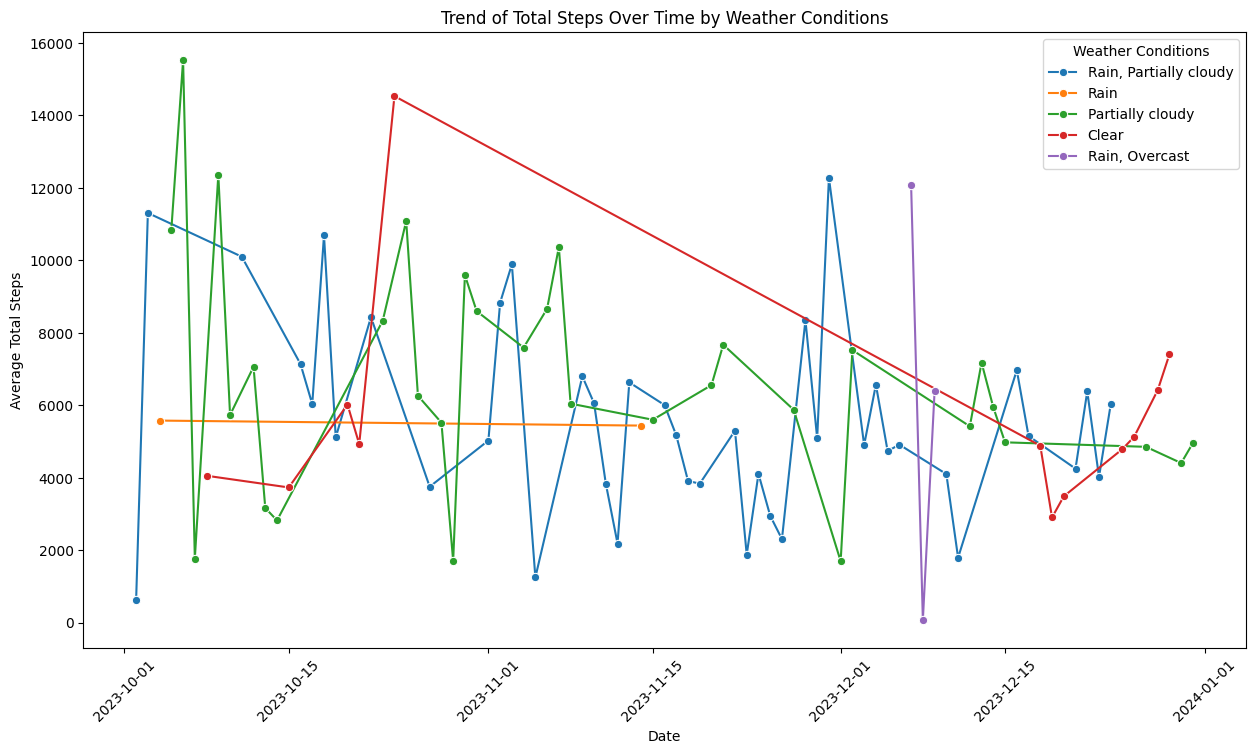

In [ ]:
# To compare the trend of total steps with weather conditions, we will create a line plot
# with multiple lines, one for each weather condition

# First, we need to group the data by both date and weather conditions and calculate mean total steps
trend_data_by_weather = merged_data.groupby(['Date', 'Weather Conditions'])['Total Steps'].mean().reset_index()

# Creating the line plot with multiple lines representing different weather conditions
plt.figure(figsize=(15, 8))
sns.lineplot(x='Date', y='Total Steps', hue='Weather Conditions', data=trend_data_by_weather, marker='o')

# Adding title and labels
plt.title('Trend of Total Steps Over Time by Weather Conditions')
plt.xlabel('Date')
plt.ylabel('Average Total Steps')

# Adding a legend
plt.legend(title='Weather Conditions', loc='upper right')

# Displaying the trend line
plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability
plt.show()

<ipython-input-28-15bfc8b9a16b>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = trend_data_by_weather.pivot("Date", "Weather Conditions", "Total Steps")


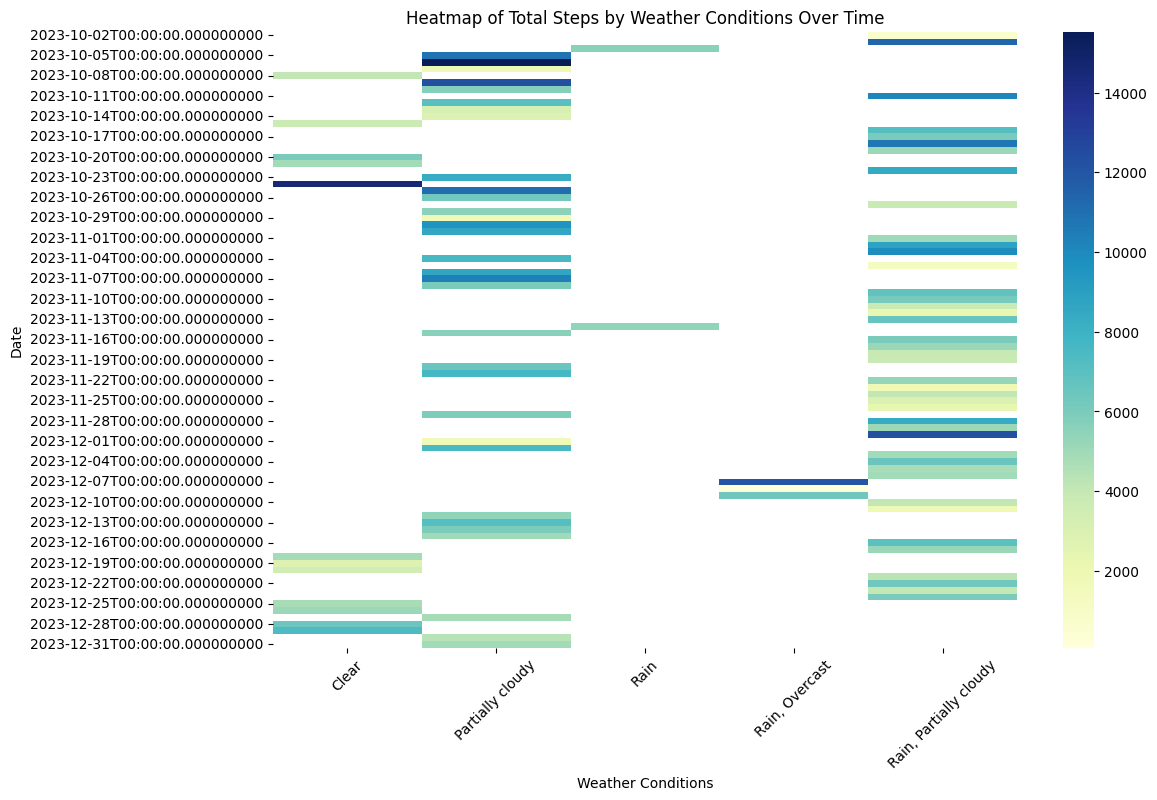

In [ ]:
# Creating a heatmap to visualize the average total steps by weather conditions over time

# First, we need to pivot the data to get a matrix form suitable for a heatmap
heatmap_data = trend_data_by_weather.pivot("Date", "Weather Conditions", "Total Steps")

# Creating the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=False)

# Adding title and labels
plt.title('Heatmap of Total Steps by Weather Conditions Over Time')
plt.xlabel('Weather Conditions')
plt.ylabel('Date')

# Displaying the heatmap
plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability
plt.show()

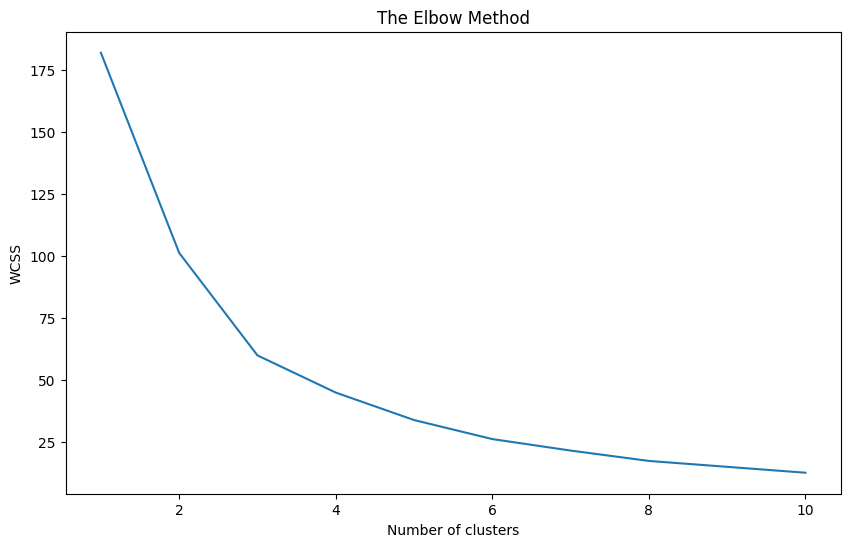

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Since we are focusing on the effect of weather conditions on step counts,
# we will convert weather conditions into numerical values and use them with step counts for clustering

# Converting weather conditions into numerical values
merged_data['Weather Conditions Numerical'] = merged_data['Weather Conditions'].map(weather_conditions_mapping)

# Preparing the data for clustering
X = merged_data[['Total Steps', 'Weather Conditions Numerical']]

# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determining the optimal number of clusters using the Elbow Method
wcss = []  # Within-Cluster Sum of Square
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plotting the results of the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Verilerinizi y ve X olarak ayırın (X bağımsız değişkenleri içerir)
y = merged_data['Total Steps']
X = merged_data[['Weather Conditions Numerical']]

# Eğitim ve test verilerini ayırın (örneğin, %80 eğitim, %20 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Lineer Regresyon modelini oluşturun ve eğitin
model = LinearRegression()
model.fit(X_train, y_train)

# Tahminleri yapın
y_pred = model.predict(X_test)

# Katsayıları ve kesme noktasını alın
coefficients = model.coef_
intercept = model.intercept_

# R² skorunu hesaplayın
r2 = model.score(X_test, y_test)

# Manuel R² skoru hesaplamak için
y_mean = np.mean(y_test)
ssr = np.sum((y_pred - y_mean) ** 2)
sst = np.sum((y_test - y_mean) ** 2)
r2_manual = ssr / sst

# Hata metriklerini hesaplayın
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Katsayıları, kesme noktasını ve hata metriklerini yazdırın
print(f"Katsayılar: {coefficients}")
print(f"Kesme noktası (intercept): {intercept}")
print(f"R² skoru: {r2}")
print(f"Manuel R² skoru: {r2_manual}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Katsayılar: [-273.05549872]
Kesme noktası (intercept): 6177.465984654732
R² skoru: -0.17004840487449924
Manuel R² skoru: 0.062143369089733946
Mean Absolute Error (MAE): 3095.9075245658905
Mean Squared Error (MSE): 18072986.8436868
Root Mean Squared Error (RMSE): 4251.233567293945


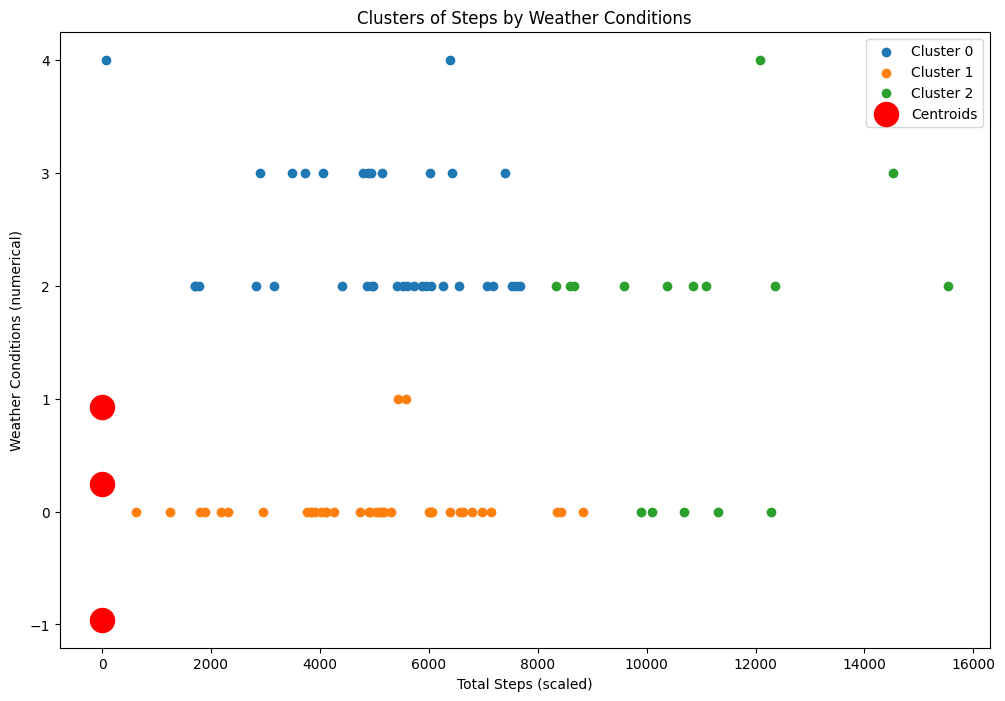

,Weather Conditions,Date,Total Steps,Weather Conditions Numerical,Cluster
0,"Rain, Partially cloudy",2023-10-02,621.0,0,1
1,"Rain, Partially cloudy",2023-10-03,11309.0,0,2
2,Rain,2023-10-04,5580.0,1,1
3,Partially cloudy,2023-10-05,10851.0,2,2
4,Partially cloudy,2023-10-06,15525.0,2,2


In [ ]:
# Applying KMeans clustering with 3 clusters based on the user's choice

# Creating a KMeans model with 3 clusters
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)

# Fitting the model and predicting cluster labels
cluster_labels = kmeans.fit_predict(X_scaled)

# Adding the cluster labels to our original data
merged_data['Cluster'] = cluster_labels

# Plotting the clusters
plt.figure(figsize=(12, 8))

# Plotting each cluster with a different color
for i in range(kmeans.n_clusters):
    plt.scatter(merged_data[merged_data['Cluster'] == i]['Total Steps'],
                merged_data[merged_data['Cluster'] == i]['Weather Conditions Numerical'],
                label=f'Cluster {i}')

# Adding centroids to the plot
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', label='Centroids')

# Adding title and labels
plt.title('Clusters of Steps by Weather Conditions')
plt.xlabel('Total Steps (scaled)')
plt.ylabel('Weather Conditions (numerical)')
plt.legend()

# Displaying the plot
plt.show()

# Returning the first few rows of the data with cluster labels
merged_data.head()